In [1]:
!pip install tweet-preprocessor
# !pip install flair
!pip install datasets
!pip install transformers[sentencepiece]
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer
import preprocessor as p

from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
import torch
from transformers import TFDistilBertForSequenceClassification, TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import yfinance as yf

# import flair

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# pre-pro

In [3]:
### fine tune distilbert for twitter sentiment
  # old data, thus different internet slang!
  # compare different embedding strategies: bert, 

In [4]:
### kaggle api

from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [5]:
!kaggle datasets download -d kazanova/sentiment140

 95% 77.0M/80.9M [00:00<00:00, 292MB/s]
100% 80.9M/80.9M [00:00<00:00, 271MB/s]


In [6]:
# document assembler
# word-piece tokenization = token+lemmatize
# normalizer = mentions, url, hashtag, lowercase
# spelling
# stop-words cleaner

In [7]:
testing_df = pd.read_csv("/content/sentiment140.zip",encoding="ISO-8859-1")
testing_df= testing_df.iloc[:,[0,-1]]
testing_df.columns = ['labels','tweet']
testing_df = pd.concat([testing_df.query("labels==0").sample(500000),testing_df.query("labels==4").sample(500000)])
testing_df.labels = testing_df.labels.map({0:0,4:1})
testing_df =  shuffle(testing_df).reset_index(drop=True)

In [8]:
testing_df.head()

,labels,tweet
0,1,@JustCallMeK Geesh your a little machine. atta...
1,0,so is anyone gonna send in a request to be in ...
2,0,Red John is no Jack of all trades.. I miss Pr...
3,0,UGH. I need to buy a bag. I have too much stu...
4,0,@nunokaka85 waaaaaaaahhhhhh i dont have have a...


In [9]:
def clean_tweet(row):
      text = row['tweet']
      p.set_options(p.OPT.EMOJI,p.OPT.HASHTAG,p.OPT.MENTION,p.OPT.RESERVED,p.OPT.SMILEY,p.OPT.URL)
      text = p.clean(text)
      return text

clean = testing_df.apply(clean_tweet, axis=1)
testing_df['tweet'] = clean
testing_df = testing_df[testing_df['tweet'] != '']

In [ ]:
def preprocess_data(data):

  def clean_tweet(row):
      text = row['tweet']
      p.set_options(p.OPT.EMOJI,p.OPT.HASHTAG,p.OPT.MENTION,p.OPT.NUMBER,p.OPT.RESERVED,p.OPT.SMILEY,p.OPT.URL)
      text = p.clean(text)
      return text

  clean = df.apply(clean_tweet, axis=1)
  lower_text = clean.str.lower()
  lemmatizer = nltk.stem.WordNetLemmatizer()
  w_tokenizer =  TweetTokenizer()
 
  def lemmatize_text(text):
    return [(lemmatizer.lemmatize(w)) for w \
                       in w_tokenizer.tokenize((text))]

  def remove_punctuation(words):
    new_words = []
    for word in words:
       new_word = re.sub(r'[^\w\s]', '', (word))
       if new_word != '':
          new_words.append(new_word)
    return new_words

  words = lower_text.apply(lemmatize_text)
  words = words.apply(remove_punctuation)

  return pd.DataFrame(words)

# tf fine-tune distilBERT

In [13]:
dataset = Dataset.from_pandas(testing_df).train_test_split(train_size=0.99, seed=42)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['labels', 'tweet', '__index_level_0__'],
        num_rows: 988006
    })
    test: Dataset({
        features: ['labels', 'tweet', '__index_level_0__'],
        num_rows: 9980
    })
})


In [14]:
dataset = dataset.class_encode_column("labels")

Stringifying the column:   0%|          | 0/989 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/989 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/10 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/10 [00:00<?, ?ba/s]

In [15]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    tokenized_batch = tokenizer(batch['tweet'],   # tokenize the "tweet" column
                                padding=True,     # 
                                truncation=True, 
                                max_length=512)
    return tokenized_batch


dataset_enc = dataset.map(tokenize, batched=True, num_proc=1)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/989 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [16]:
# Set dataset format for tf
dataset_enc.set_format('tensorflow')

# Check the output
print(dataset_enc["train"].column_names)    # ['labels', 'tweet', '__index_level_0__', 'input_ids', 'attention_mask']

['labels', 'tweet', '__index_level_0__', 'input_ids', 'attention_mask']


In [17]:
# Instantiate a data collator with dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# call dataset.to_tf_dataset:
ds_train = dataset_enc["train"].to_tf_dataset(
   columns=['input_ids', 'attention_mask', 'labels'],
   shuffle=False,
   batch_size=32,
   collate_fn=data_collator,
   label_cols='labels'
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [18]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [19]:
### obsolete ###
# tf_dataset = model.prepare_tf_dataset(dataset_enc['train'], batch_size=16, shuffle=False, tokenizer=tokenizer)

In [20]:
model.compile(optimizer=Adam(5e-5),                                     
              metrics=['accuracy'])

model.fit(ds_train)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


30876/30876 [==============================] - 6229s 201ms/step - loss: 0.3570 - accuracy: 0.8430


In [21]:
# evaluate:
ds_test = dataset_enc["test"].to_tf_dataset(
   columns=['input_ids', 'attention_mask', 'labels'],
   shuffle=False,
   batch_size=64,
   collate_fn=data_collator,
   label_cols='labels'
)
model.evaluate(ds_test, return_dict=True)

156/156 [==============================] - 23s 138ms/step - loss: 0.3382 - accuracy: 0.8531


{'loss': 0.33823317289352417, 'accuracy': 0.8531062006950378}

In [22]:
def predict_proba(text_list, model, tokenizer):
  """
  To get array with predicted probabilities for 0 - negative, 1- positive
  for each paragraph in the list of strings
  :param text_list: list[str]
  :param model: transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertForSequenceClassification
  :param tokenizer: transformers.models.distilbert.tokenization_distilbert.DistilBertTokenizer
  :return res: numpy.ndarray
  """
     
  encodings = tokenizer(text_list, truncation=True, padding=True)
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings))) 
  preds = model.predict(dataset.batch(1)).logits
  res = tf.nn.softmax(preds, axis=1).numpy()
    
  return res

In [23]:
strings_list =["I hate it here!", "The stock market looks rough today...", "WOW ILY!!", "Bro this cake is so good"]
predict_proba(strings_list, model, tokenizer)

4/4 [==============================] - 1s 13ms/step


array([[0.98451483, 0.01548514],
       [0.94965047, 0.05034955],
       [0.29120654, 0.70879346],
       [0.09239212, 0.9076079 ]], dtype=float32)

In [24]:
model.save_pretrained("models/distilbert-sentiment-tweets")

# pytorch fine-tune distilBERT

In [10]:
# Put clean data in a dataset split into train and test sets
dataset = Dataset.from_pandas(testing_df).train_test_split(train_size=0.99, seed=42)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['labels', 'tweet', '__index_level_0__'],
        num_rows: 1580924
    })
    test: Dataset({
        features: ['labels', 'tweet', '__index_level_0__'],
        num_rows: 15969
    })
})


In [11]:
# Cast labels column as class labels
dataset = dataset.class_encode_column("labels")

Stringifying the column:   0%|          | 0/1581 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1581 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/16 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/16 [00:00<?, ?ba/s]

In [12]:
# Load DistilBERT tokenizer and tokenize (encode) the texts
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained('philschmid/DistilBERT-tweet-eval-emotion')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# Tokenize and encode the dataset
def tokenize(batch):
    tokenized_batch = tokenizer(batch['tweet'],   # tokenize the "tweet" column
                                padding=True,     # 
                                truncation=True, 
                                max_length=512)
    return tokenized_batch

dataset_enc = dataset.map(tokenize, batched=True, num_proc=1)

# Set dataset format for PyTorch
dataset_enc.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Check the output
print(dataset_enc["train"].column_names)    # ['labels', 'tweet', 'input_ids', 'attention_mask']

  0%|          | 0/1581 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

['labels', 'tweet', '__index_level_0__', 'input_ids', 'attention_mask']


In [14]:
# Instantiate a data collator with dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create data loaders for to reshape data for PyTorch model
train_dataloader = DataLoader(
    dataset_enc["train"], shuffle=True, batch_size=64, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    dataset_enc["test"], batch_size=64, collate_fn=data_collator
)

In [15]:
# Dynamically set number of class labels based on dataset
num_labels = dataset["train"].features["labels"].num_classes
print(f"Number of labels: {num_labels}")

# Load model from checkpoint
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                           num_labels=num_labels)

Number of labels: 2


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [16]:
# Model parameters
learning_rate = 5e-2
num_epochs = 1

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Further define learning rate scheduler
num_training_batches = len(train_dataloader)
num_training_steps = num_epochs * num_training_batches
lr_scheduler = get_scheduler(
    "linear",                   # linear decay
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Set the device automatically (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Move model to device
model.to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


cuda


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [17]:
# Train the model with PyTorch training loop
progress_bar = tqdm(range(num_training_steps))
model.train()
_metrics = []
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    ### save accuracy & f1
    # Load metric
    metric = load_metric("glue", "mrpc")

    # Iteratively evaluate the model and compute metrics
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    _metrics.append(metric.compute())  # [{'accuracy', 'f1'}, {'accuracy', 'f1'}, {'accuracy', 'f1'}, ...]

    # model.save_pretrained(f"models/{epoch}/distilbert-sentiment-tweets")

  0%|          | 0/24702 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
<ipython-input-17-cfd80fd331b7>:19: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "mrpc")


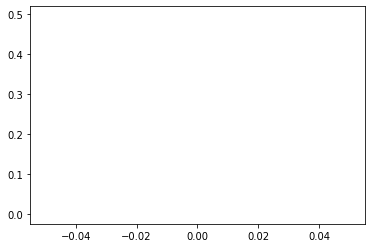

In [18]:
# plot accuracy & f1
metrics_df = pd.DataFrame(_metrics)

plt.figure(1)
plt.plot(metrics_df['accuracy'],label='accuracy')
plt.plot(metrics_df['f1'],label='f1')
plt.show()

In [21]:
# Load metric
metric = load_metric("glue", "mrpc")

# Iteratively evaluate the model and compute metrics
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

# Get model accuracy and F1 score
metric.compute()

#0: {'accuracy': 0.5056875, 'f1': 0.0}
#1: {'accuracy': 0.8634375, 'f1': 0.8631723965182541}
#5: {'accuracy': 0.82, 'f1': 0.82}

{'accuracy': 0.4952094683449183, 'f1': 0.0}

## save model

In [ ]:
# load pytorch model into TFPreTrained()

from transformers import TFDistilBertForSequenceClassification
tf_model = TFDistilBertForSequenceClassification.from_pretrained("/content/models/0/distilbert-sentiment-tweets", from_pt=True)

In [ ]:
MODEL_NAME = "distilbert-base-uncased"
# save tokenizer
tokenizer.save_pretrained('./{}_tokenizer/'.format(MODEL_NAME))
# save model
model.save_pretrained("./{}".format(MODEL_NAME), saved_model=True)

In [ ]:
!ls -l {MODEL_NAME}

In [ ]:
!ls -l {MODEL_NAME}/saved_model/1

In [ ]:
!ls -l {MODEL_NAME}_tokenizer

- As you can see, we need the SavedModel from `saved_model/1/` path
- We also be needing `vocab.txt` from the tokenizer
- All we need is to just copy the `vocab.txt` to `saved_model/1/assets` which Spark NLP will look for
- In addition to vocabs, we also need `labels` and their `ids` which is saved inside the model's config. We will save this inside `labels.txt`

In [ ]:
asset_path = '{}/saved_model/1/assets'.format(MODEL_NAME)

!cp {MODEL_NAME}_tokenizer/vocab.txt {asset_path}

In [ ]:
# get label2id dictionary 
labels = model.config.label2id
# sort the dictionary based on the id
labels = sorted(labels, key=labels.get)

with open(asset_path+'/labels.txt', 'w') as f:
    f.write('\n'.join(labels))

Voila! We have our `vocab.txt` and `labels.txt` inside assets directory. This directory was imported into DBFS for use in MLFlow model registry.

In [ ]:
!ls -l {MODEL_NAME}/saved_model/1/assets